In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk # sudo pip3 install lightkurve
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 22}	
plt.rc('font', **font)
import shallue_vanderburg_util.preprocess.kepler_io as kepler_io 
## These are the import statments in kepler_io
# import os.path
# from os import path
# from astropy.io import fits
# import numpy as np
## If you don't have astopy, sudo pip3 install astropy

from lightkurve import *

In [104]:
# TCE_DIR = "dr24_tce.csv"
# QUARTER_ARR = [{'Quarter':0,'Start':120.5,'End':129.5},{'Quarter':1,'Start':131.5,'End':164.5},{'Quarter':2,'Start':169.5,'End':257.5},{'Quarter':3,'Start':259.5,'End':348.5},{'Quarter':4,'Start':351.5,'End':441.5},{'Quarter':5,'Start':442.5,'End':537.5},{'Quarter':6,'Start':538.5,'End':628.5},{'Quarter':7,'Start':629.5,'End':719.5},{'Quarter':8,'Start':719.5,'End':811.5},{'Quarter':9,'Start':806.5,'End':906.5},{'Quarter':10,'Start':907.5,'End':998.5},{'Quarter':11,'Start':1000.5,'End':1097.5},{'Quarter':12,'Start':1098.5,'End':1181.5},{'Quarter':13,'Start':1182.5,'End':1272.5},{'Quarter':14,'Start':1273.5,'End':1370.5},{'Quarter':15,'Start':1372.5,'End':1470.5},{'Quarter':16,'Start':1471.5,'End':1557.5},{'Quarter':17,'Start':1558.5,'End':1587.5}]
TCE_DIR = "dr24_tce_full.csv"
tce_df = pd.read_csv(TCE_DIR, skiprows=159)

# k90 = tce_df[tce_df.kepid == 11442793]
# row = k90.iloc[0]


# row = tce_df[tce_df.kepid == 6022556].iloc[0]
# row = tce_df[tce_df.kepid == 11442793].iloc[0]
row = tce_df[tce_df.kepid == 1718189 & tce_df.tce_plnt_num == 1].iloc[0]
# row = k90

# row = tce_df.iloc[20367-1]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [102]:
"""
You need to store the 87.23 GB kepler directory outside of github's reach. You don't want to commit that. 

Here's a file system that would work with the existing code.
/SIR/kepler
/SIR/PlanetHuntersRepo/dr24_tce
/SIR/PlanetHuntersRepo/dataCleansing.ipynb
/SIR/PlanetHuntersRepo/kepler_io.py

"""

KEPLER_DATA_DIR = "../kepler/"

# Read the light curve.
file_names = kepler_io.kepler_filenames(KEPLER_DATA_DIR, row.kepid)
assert file_names, "Failed to find .fits files in {}".format(KEPLER_DATA_DIR)

all_time, all_flux = kepler_io.read_kepler_light_curve(file_names)
print("Read light curve with {} segments".format(len(all_time)))



Read light curve with 17 segments


In [98]:
# Feed lightcurve into lightkurve engine
filename = file_names[0]
transit_time = row['tce_time0bk']
transit_type = row['av_training_set']
print(transit_type)
ind = (row.name)
transit_quarter = None

transit_lc = None    

for filename in file_names:
    lc = lk.lightcurvefile.KeplerLightCurveFile(filename)
    start = lc.time[0]
    end = lc.time[-1]
    print(start, end)
    if (transit_time < end) and (transit_time > start):
        transit_lc = lc
        
        break
        
if transit_lc == None:
    print(row.tce_quarters)
    print(transit_time)
    print("WARNING: COULD NOT FIND LIGHT CURVE FILE FOR ROW \n{}".format(row))

sap_lc = transit_lc.SAP_FLUX
pdcsap_lc = transit_lc.PDCSAP_FLUX

PC
131.512708802 164.98434332


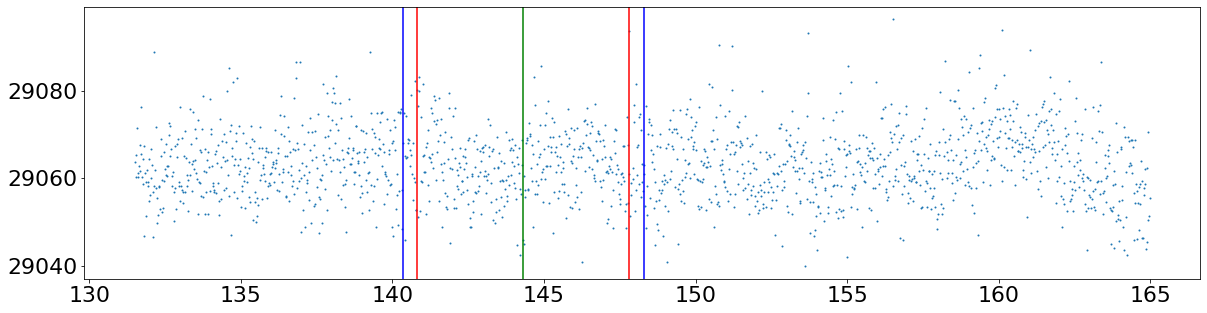

In [99]:
def annotate_transit(lc, r):
    plt.figure(figsize=(20,5))
    plt.plot(lc.time, lc.flux, 'o', markersize=1)

    transit_duration = r.tce_duration
    transit_duration_plus_err = r.tce_duration + r.tce_duration_err

    plt.axvline(x=transit_time+transit_duration, c='r')
    plt.axvline(x=transit_time-transit_duration, c='r')
    plt.axvline(x=transit_time-transit_duration_plus_err, c='b')
    plt.axvline(x=transit_time+transit_duration_plus_err, c='b')
    plt.axvline(x=transit_time, c='g')
    
annotate_transit(pdcsap_lc, row)

The following cell shows the difference between raw SAP_FLUX and cleansing with KeplerCBVCorrector.
The math is briefly described in the docs: https://docs.lightkurve.org/api/lightkurve.correctors.KeplerCBVCorrector.html#lightkurve.correctors.KeplerCBVCorrector

The result of using CBV is extremely similar to (yet not identical to) PDCSAP_FLUX, provided by NASA with the downloaded lightcurve files. However, NASA's method is "subject to change," meaning that their documentation could be updated to describe a different method than what was used when the data was previously downloaded. 

Additionally, CBV is something that we can control when generating simulated transits.

In [106]:
cbv_lc = KeplerCBVCorrector(sap_lc).correct()
print(sap_lc)
sap_lc.scatter(label="Raw SAP_FLUX: TCE {}-{}".format(sap_lc.targetid, sap_lc.tce_plnt_num))
cbv_lc.scatter(label="Lightkurve's CBV_FLUX: TCE {}-{}".format(cbv_lc.targetid, cbv_lc.quarter))
pdcsap_lc.scatter(label="NASA's PDCSAP_FLUX: TCE {}-{}".format(pdcsap_lc.targetid, pdcsap_lc.quarter))

KeplerLightCurve(ID: 1718189)


AttributeError: 'KeplerLightCurve' object has no attribute 'tce_plnt_num'

As CBV_FLUX and PDCSAP_FLUX can appear to be identical when plotted on two separate graphs, the following plot shows the two on the same graph.

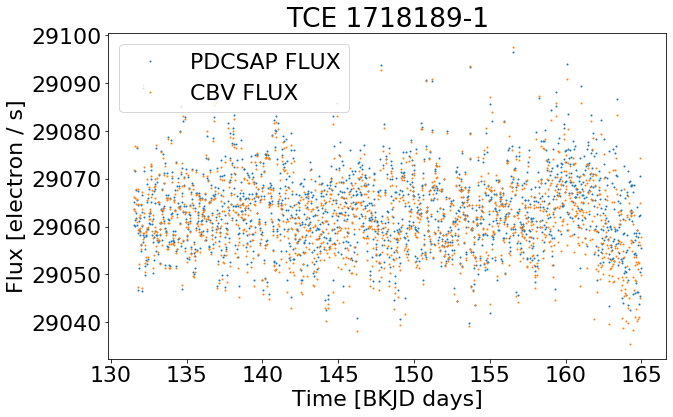

In [72]:
plt.figure(figsize=(10,6))
plt.plot(pdcsap_lc.time, pdcsap_lc.flux, 'o', markersize=1, label='PDCSAP FLUX')
plt.plot(cbv_lc.time, cbv_lc.flux, 'o', markersize=1, label='CBV FLUX')
plt.title("TCE {}-{}".format(pdcsap_lc.targetid, pdcsap_lc.quarter))
plt.ylabel("Flux [{}]".format(cbv_lc.flux_unit))
plt.xlabel("Time [{} days]".format(cbv_lc.time_format.upper()))
plt.legend()

The following method flattens the cbv lightcurve using a Savitzky-Golay filter.


Docs: https://docs.lightkurve.org/api/lightkurve.lightcurve.KeplerLightCurve.html#lightkurve.lightcurve.KeplerLightCurve.flatten


Savitzky-Golay filter https://en.wikipedia.org/wiki/Savitzky–Golay_filter

In [73]:
flat_lc = cbv_lc.flatten()
flat_lc.scatte(label="Flattened CBV_FLUX: TCE {}-{}".format(flat_lc.targetid, flat_lc.quarter))

AttributeError: 'KeplerLightCurve' object has no attribute 'scatte'

The following removes >3σ outliers from the median using lightkurve's "remove_outliers" function. 

The current issue with this is that it erases the transit entirely. What we need to do is center the 

In [74]:
def remove_outliers_with_protected_range(lc, r):
    time, duration = r['tce_time0bk'], (r['tce_duration']+r['tce_duration_err'])/24.0
    upperBoundTime = time + duration
    lowerBoundTime = time - duration
    outlier_mask = lc.remove_outliers(sigma=3.0, return_mask=True)[1] # True for all >3σ points from the median
    newFlux = []
    for i, t in enumerate(lc.time):
        isOutlier = outlier_mask[i]
        flux = lc.flux[i]
        isProtected = (t > lowerBoundTime) and (t < upperBoundTime)
        append_flux = flux if isProtected or (not isOutlier) else np.nan
        newFlux.append(append_flux)
    lc.flux = np.array(newFlux)
    return lc

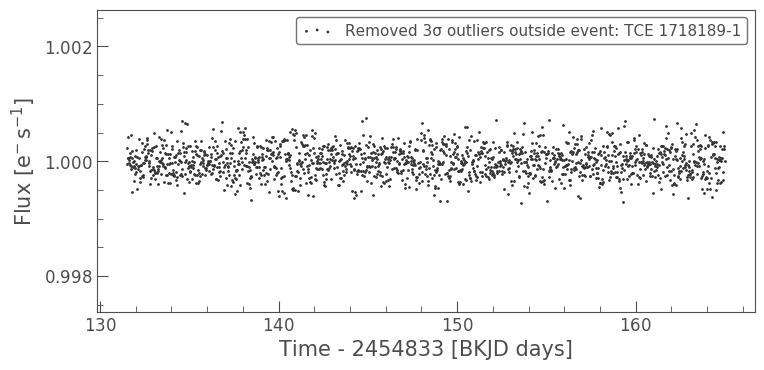

In [75]:
removed_outliers = remove_outliers_with_protected_range(flat_lc, row)
removed_outliers.scatter(label="Removed 3σ outliers outside event: TCE {}-{}".format(removed_outliers.targetid, removed_outliers.quarter))


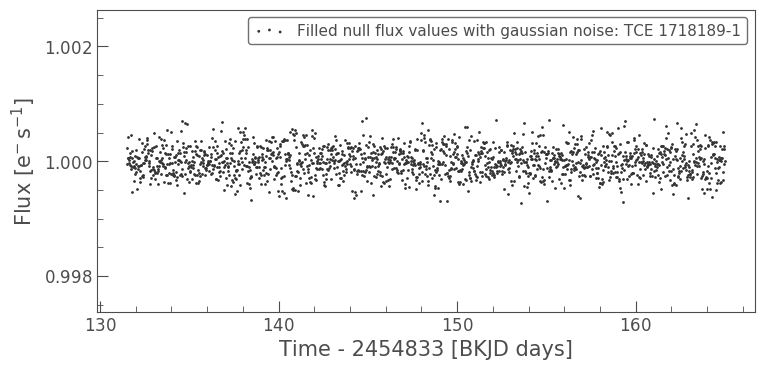

In [76]:
#TODO: Make this cleaner
filled_lc = removed_outliers.fill_gaps()
filled_lc.scatter(label="Filled null flux values with gaussian noise: TCE {}-{}".format(filled_lc.targetid, filled_lc.quarter))

In [77]:
def focus_event(lc, r):
    time = r['tce_time0bk']
    lc = lc.fold(time)
    return lc

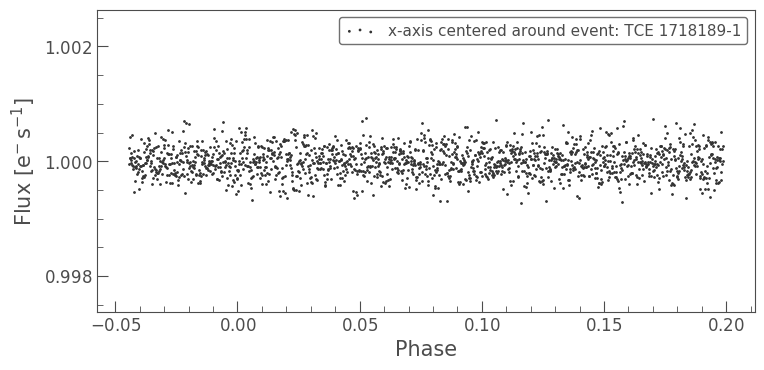

In [78]:
folded_lc = focus_event(filled_lc, row)
folded_lc.scatter(label="x-axis centered around event: TCE {}-{}".format(filled_lc.targetid, filled_lc.quarter))

In [79]:
folded_lc.time.max()

0.19870921872732006

In [80]:
def center_via_paste_method(folded_lc):
    mx = folded_lc.time.max() # maximum phase given
    mn = folded_lc.time.min() # minimum phase given
    md = (mx + mn) / 2.0 # median between max and min
    d = np.median(np.diff(folded_lc.time)) # get median phase difference between points
    f = folded_lc.flux
    roll_by = int(md/d) # Not expected to have divide by zero issues, but it's possible.
    folded_lc.flux = np.roll(f, roll_by)
    folded_lc = folded_lc.fold(1, t0=md)
    return folded_lc
    
    
centered_lc = center_via_paste_method(folded_lc)

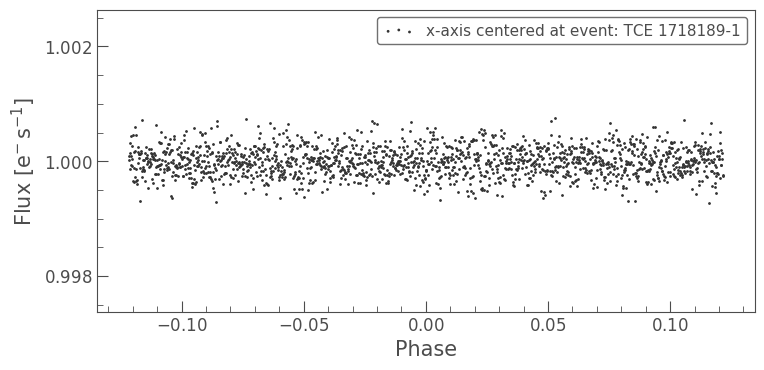

In [81]:
centered_lc.scatter(label="x-axis centered at event: TCE {}-{}".format(filled_lc.targetid, filled_lc.quarter))

In [62]:
transit_duration = row.tce_duration
transit_period = row.tce_period
print(transit_duration, transit_period)

6.076 1.93652


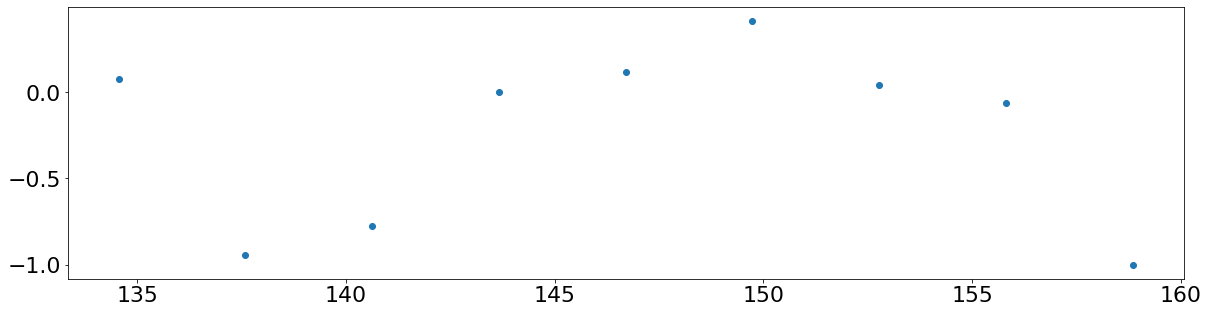

In [63]:
def normalize_zero_negative_one(arr):
    arr = arr - np.median(arr)
    arr = arr * (-1/np.min(arr))
    return arr

def shallue_vanderburg_bin(lc, delta, lambd):
    plt.figure(figsize=(20,5))
    f = lc.flux
    binned = []
    half_bin = delta/2.0
    c = half_bin
    while c + half_bin + lambd < len(f):
        a = int(c - half_bin)
        b = int(c + half_bin)
        if b-a==0:
            raise Exception("Delta of {} is not large enough.".format(delta))
        med = np.median(f[a:b])
        binned.append(med)
        c += lambd
        
    binned_flux = normalize_zero_negative_one(np.array(binned))
    binned_flux = binned_flux - np.median(binned_flux)
    binned_flux = binned_flux * (-1/np.min(binned_flux))
    
    plt.scatter(np.arange(len(binned_flux)), binned_flux)
    plt.show()
    
# Modified from https://stackoverflow.com/a/2566508/5160929    
def index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def shallue_vanderburg_bin_2(lc, delta, lambd):
    plt.figure(figsize=(20,5))
    f = lc.flux
    t = lc.time
    
    max_t = np.max(t)
    
    bin_f = []
    times = []
    half_bin = delta/2.0
    c = np.min(t) + half_bin
    
    while c + half_bin + lambd < max_t:
        a = index_of_nearest(t, c - half_bin)
        b = index_of_nearest(t, c + half_bin)
        if b-a<=0:
            raise Exception("Delta of {} is not large enough for lambda {}.".format(delta, lambd))
        med = np.median(f[a:b])
        bin_f.append(med)
        times.append(c)
        c += lambd
        
    binned_flux = normalize_zero_negative_one(np.array(bin_f))
    binned_flux = binned_flux - np.median(binned_flux)
    binned_flux = binned_flux * (-1/np.min(binned_flux))
    
    plt.scatter(np.array(times), binned_flux)
    plt.show()

    
filled_lc.flux = centered_lc.flux
# shallue_vanderburg_bin_2(filled_lc, 5, .25)
# transit_duration, transit_period
shallue_vanderburg_bin_2(filled_lc, transit_duration, transit_duration * 0.5)


# shallue_vanderburg_bin(centered_lc, 1, 1)
    

In [64]:
a = bin_and_aggregate(centered_lc.time, centered_lc.flux, 200)[0]

binned_flux = normalize_zero_negative_one(a)
plt.scatter(np.arange(len(a)), binned_flux)

NameError: name 'bin_and_aggregate' is not defined

  av_training_set  tce_period  tce_duration  tce_time0bk    kepid  \
0             AFP    0.831850         2.392      132.227  1162345   
3             AFP    0.831833         2.181      131.919  1162345   
5              PC    8.884920         2.078      134.452   757450   
6             NTP    2.262110         7.509      132.171   892667   
7             AFP    5.092600         3.399      133.451   892772   

   tce_plnt_num  
0             2  
3             3  
5             1  
6             1  
7             1  
a
b
c
d
e
f
g


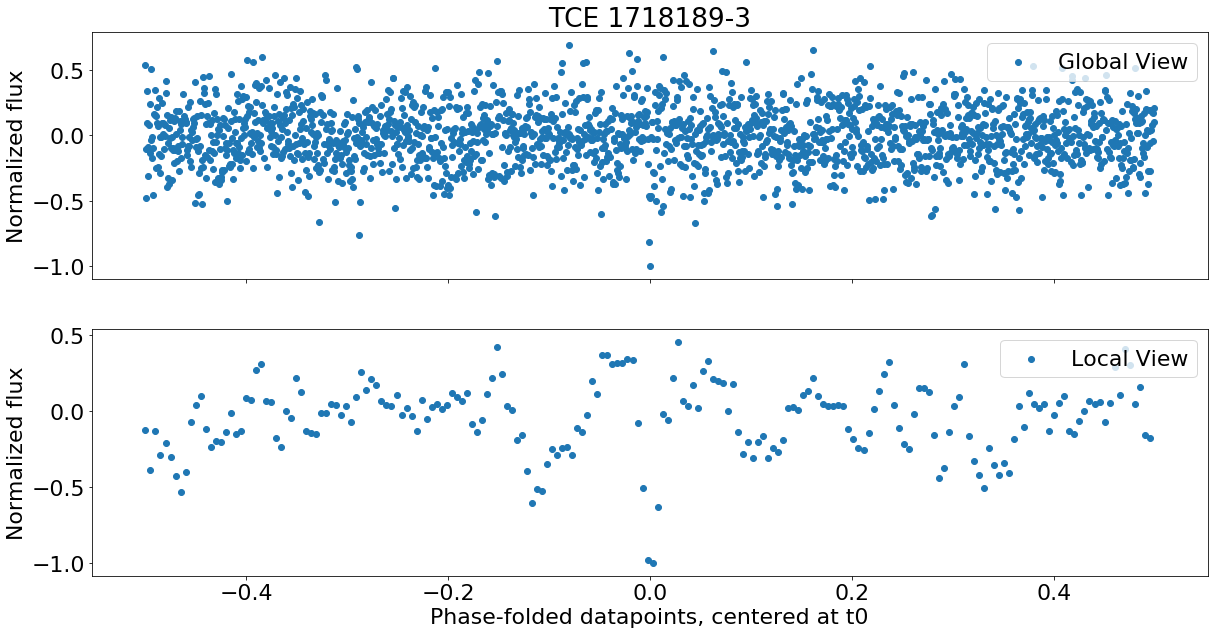

In [66]:
from shallue_vanderburg_util.preprocess.preprocess import *
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
import time
import pickle
# from lightkurve import *
TCE_DIR = "dr24_tce_full.csv"
KEPLER_DATA_DIR = "../kepler/"
FIG_DIM = (20, 10)
TCE_DIR = "dr24_tce_full.csv"
tce_df = pd.read_csv(TCE_DIR, skiprows=159)
cols = ["av_training_set", "tce_period", "tce_duration", "tce_time0bk", "kepid", "tce_plnt_num"]
tce_df = tce_df[cols]
tce_df = tce_df[tce_df.av_training_set.isin(["AFP", "NTP", "PC"])]
print(tce_df.head())

def fetch_data_from_row(row):
    tce = tce_df.iloc[row]
    period = tce["tce_period"]
    duration = tce["tce_duration"]
    t0 = tce["tce_time0bk"]
    kepid = tce["kepid"]
    planet_num = tce["tce_plnt_num"]
    train_set = tce["av_training_set"]
    return kepid, t0, period, duration, planet_num, train_set
    
def get_normalized_curve_from_row(row):
    kepid, t0, period, duration, planet_num, train_set = fetch_data_from_row(row)
    all_time, all_flux = read_light_curve(kepid, KEPLER_DATA_DIR)
    time, flux = process_light_curve(all_time, all_flux)
    folded_time, folded_values = phase_fold_and_sort_light_curve(time, flux, period, t0)
    return folded_time, folded_values, period, duration, kepid, planet_num, train_set

def scatter_lg(d, label, ax, xlbl=None, title=None):
    ax.scatter(np.arange(-0.5, 0.5, 1/len(d)), d, label=label)
    ax.set_ylabel("Normalized flux")
    if xlbl:
        ax.set_xlabel(xlbl)
    if title:
        ax.set_title(title)
    ax.legend(loc='upper right')
    
    
def save_local_global_of_row_index(row):
    font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 22}	
    plt.rc('font', **font)
    folded_time, folded_values, period, duration, kepid, planet_num, train_set = get_normalized_curve_from_row(row)
    g = global_view(folded_time, folded_values, period)
    l = local_view(folded_time, folded_values, period, duration)
    fig, axs = plt.subplots(2, sharex=True, figsize=FIG_DIM)
    scatter_lg(g, "Global View", axs[0], title="TCE {}-{}".format(kepid, planet_num))
    scatter_lg(l, "Local View", axs[1], xlbl="Phase-folded datapoints, centered at t0")

save_local_global_of_row_index(298)